#NeuralNetworks


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import io, special, optimize
import numpy as np
from __future__ import division
%matplotlib inline

C:\Users\TJ\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


$\\$

$\\$

$\\$

$\\$

## Neural Network class



In [2]:
# given input of a list a matrices, returns all matrices as a 1-D vector, used in optimization
def concat(matrix_list):
    unrolled = matrix_list[0].ravel()
    for i in range(1,len(matrix_list)):
        unrolled = np.insert(unrolled,len(unrolled),matrix_list[i].ravel())
    return unrolled


# rebuilds a 1-D vector into the list of matrices that can be used in computation
def rebuild_matrices(matrix_vec, model):

    # nxm values for first layer
    n = model.num_units_per_layer[1]
    m = model.num_units_per_layer[0] + 1

    lower_bound = 0
    upper_bound = n*m
    matrices = []


    for layer in range(1, len(model.num_units_per_layer)):

        # get rebuilt matrix for layer
        matrices.append(matrix_vec[lower_bound:upper_bound].reshape((n,m)))

        # if all matrices havent been updated, update the parameters
        if layer < len(model.num_units_per_layer) -1 :
            n = model.num_units_per_layer[layer + 1]
            m = model.num_units_per_layer[layer] + 1

            lower_bound = upper_bound
            upper_bound += n*m

    return matrices


In [3]:
class NeuralNetwork:
    '''
        Defines a class structure for handling nueral networks.
        You can describe the structure of the neural network (start with random weights), or input a 
        set of weights. 
    '''
    
    def __init__(self,num_units_per_layer = [], weights = [], regularization = 0):
        '''
        
        '''
        
        # Define the activation function using sigmoid here
        self.__act_func = special.expit
        
        self.regularization = regularization
        
        # If thetas are not provided set random thetas and 
        # set the skeleton for the neural network, ie
        # the number of hidden layers and units per layer must
        # be provided
        if len(weights) == 0:

            if len(num_units_per_layer) < 0:
                raise NameError('Must set (list) num_units_per_layer if weights not provided')
            
            # Number of hidden layers, not including input or output
            self.num_hidden_layers = len(num_units_per_layer)-2

            # List of number of neurons in each layer, including input and output
            self.num_units_per_layer = num_units_per_layer
    
            # Set random weights
            self.weights = self.__init__weights()

        else:
            
            # Set weights and number of hidden layers
            self.weights = weights
            self.num_hidden_layers = len(self.weights) - 1
            self.num_units_per_layer = [400,25,10]
        
    def __init__weights(self):
        '''set random thetas'''
        
        thetas = []
        for i in range(self.num_hidden_layers + 1):
            
            # Set n to be the image of the transformation, 
            # m to be the dimension of the input vector
            n = self.num_units_per_layer[i+1]
            m = self.num_units_per_layer[i] + 1
            
            # Define the epsilon which for which all elements in the 
            # random matrix are in [-epsilon, epsilon]
            epsilon = np.sqrt(6)/np.sqrt(n+m)
            thetas.append(np.random.rand(n,m) * 2 * epsilon - epsilon)
            
        return thetas
    
    def get_activations(self, input_vec, weights = []):
        ''' 
            returns a list of all the activations, takes up more memory then recursion but the 
            intermediate values are used for backprop
            
            input_vec -> array - values of input layer
            weights -> list of the weights
        '''
        
        # if weights is empty, then its used for testing
        if len(weights) == 0:
            weights = self.weights
        
        
        # Add bais unit to first input layer
        input_vec = np.insert(input_vec,0,1)
        activations = [input_vec]
        

        for depth in range(self.num_hidden_layers + 1):
            
            # The next layer is the activation function applied to the weights * current activation
            next_activation = self.__act_func(weights[depth].dot(activations[-1]))
            
            # Add a bais unit if the layer isn't the output layer
            if depth != self.num_hidden_layers:
                next_activation = np.insert(next_activation,0,1)
                
            activations.append(next_activation)
            
        return activations
    
    def predict(self, input_vec, weights = [], categorize = False):
        '''Get prediction for an input vector and weights'''
        
        if len(weights) == 0:
            weights = self.weights
        
        # the prediction is the last activation layer
        prediction = self.get_activations(input_vec, weights)[-1]
        
        # return the index of the highest probability if 
        # we want to categorize the output
        if categorize:
            return np.argmax(prediction) + 1
        
        return prediction

    def predict_set(self, examples, weights = [], categorize = False):
        '''Predicts a set a examples'''
    
        if len(weights) == 0:
            weights = self.weights
        
        predictions = []
        for example in examples:
            predictions.append(self.predict(example, weights, categorize))
    
        return np.array(predictions)
    
    def training_cost(self, training, answers, weights):
        '''Returns cost of training set'''
        
        cost = 0
        for example, answer in zip(training,answers):
            
            # get prediction
            output = self.predict(example, weights)
            
            # calculate cost of example
            cost += sum(-answer * np.log(output) - (1 - answer) * np.log(1-output))
        
        # return cost if no regularization
        if self.regularization == 0:
            return (1/len(training)) * cost

        # calculate regularization
        else:
            reg = 0
            for weight in weights:
                weight[:,0] = 0 # don't include bais units
                reg += sum(weight.ravel()**2)

            # return cost
            return (1/len(training)) * (cost + (self.regularization/2)*reg)
                       
            
    def back_prop(self, training, answers, weights):
        '''train neural network using back propagation'''
        
        # initalize culumative deltas and gradients
        clm_deltas = []
        gradients = []
        
        for weight in weights:
            clm_deltas.append(np.zeros(weight.shape))
        
        # for each training example and answer, do the back prop alg
        for example, answer in zip(training, answers):
            
            # get the activations for the input example
            activations = self.get_activations(example, weights)
            
            # get deltas for each layer
            deltas = []
            deltas.append(activations[-1] - answer)
            for layer in range(self.num_hidden_layers,0,-1):
                delta = weights[layer].T.dot(deltas[-1]) * activations[layer] * (1 - activations[layer])
                deltas.append( delta[1:] )
            
            # we defined the deltas backwards (easier to compute) so we have to reverse the list
            deltas.reverse()
            
            # accumulate the deltas for each layer
            for layer in range(self.num_hidden_layers+1):
                _delta = deltas[layer].reshape(-1,1)
                _activ = activations[layer].reshape(-1,1)                
                clm_deltas[layer] = clm_deltas[layer] + _delta.dot(_activ.T)
        
        # divide by num examples and add regularization cost
        for layer in range(self.num_hidden_layers+1):
            reg_weight = np.copy(weights[layer])
            reg_weight[:,0] = 0
            gradients.append(
                (1/len(training)) * (clm_deltas[layer] + self.regularization * reg_weight))
        
        return concat(gradients)
    
    def train(self,training, answers):
        
        # define wrappers for functions for use of the optimizer
        def _cost(weights_vec):
            weights = rebuild_matrices(weights_vec, self)
            return self.training_cost(training, answers, weights)
        
        def _back_prop(weights_vec):
            weights = rebuild_matrices(weights_vec, self)
            return self.back_prop(training, answers, weights)
        
        # set optimized weights
        f0 = concat(self.weights)
        opt_weight_vec = optimize.fmin_cg(_cost, f0, fprime= _back_prop)
        self.weights = rebuild_matrices(opt_weight_vec,self)

$\\$


$\\$

$\\$


$\\$

$\\$

Backprop is not the easiest algorithm to implement, let's check it with a simple example to make sure we got it right.

In [4]:
training = np.array([[1,1,1,1],[1,1,0,1],[1,0,1,0],[1,0,0,0],[0,1,0,0],[0,0,1,0],[1,0,0,1],[0,0,1,1]])

# if two of the inputs are 1, then the output is 1, if not then the ouput is 0
answers = np.array([1,1,1,0,0,0,0,1,1])

In [5]:

# define structure of the neural network, only one hidden layer
model = NeuralNetwork([4,5,1])

# start with random weightsmatrix
f0 = concat(model.weights)

def _cost(weights_vec):
    weights = rebuild_matrices(weights_vec, model)
    return model.training_cost(training, answers, weights)

def _back_prop(weights_vec):
    weights = rebuild_matrices(weights_vec, model)
    return model.back_prop(training, answers, weights)

# check the gradient
optimize.check_grad(_cost, _back_prop, f0)

5.0847784565397983e-08


$\\$

Looks good! Let's train the network

In [6]:
model.train(training, answers)

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 80
         Function evaluations: 1011
         Gradient evaluations: 1011



$\\$

The cost function is pretty low, but lets check a testing set of examples we didnt train on.

In [7]:
testing = [[1,1,0,0],[0,0,0,0],[0,1,1,0],[0,0,1,0]]
model.predict_set(testing)

array([[  1.12418898e-05],
       [  6.85642321e-09],
       [  9.99992662e-01],
       [  3.02963508e-05]])

so far so good!
$\\$

$\\$

 Let's see if it can recongize handwritten digits

In [22]:
# Load the handwritten images
raw_data = io.loadmat('ex4data1.mat')

# Define the training and classifications 
data = raw_data['X']
answers = raw_data['y']
raw_answers = raw_data['y']
answers = np.concatenate(answers)

# Convert from classifications to bool vectors
# ie -> (1,0,0,0,0,0,0,0,0,0) means 0 
# used for training neural network
new_answers = []
for answer in answers:
    _element = np.zeros(10)
    _element[answer%10] = 1
    new_answers.append(_element)
answers = new_answers

$\\$

Here are the images of the hand written digits

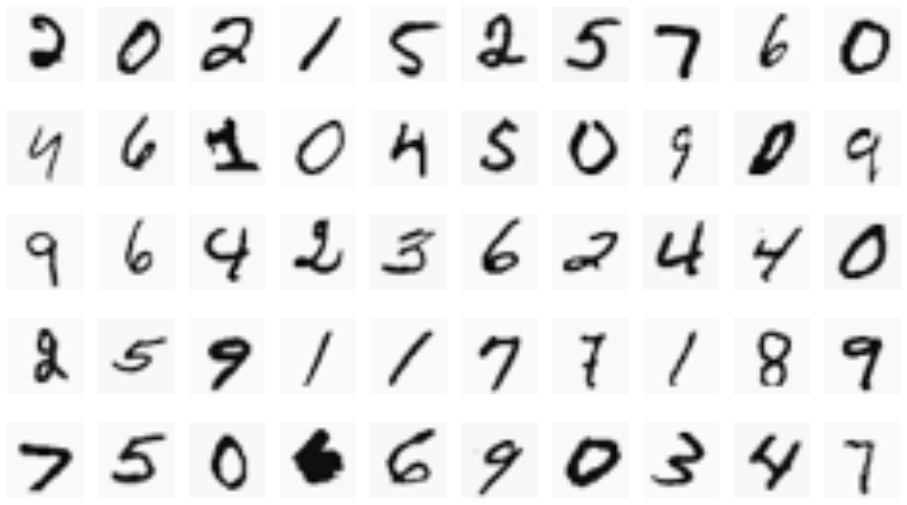

In [13]:
fig, ax = plt.subplots(5,10, figsize=(16,9))


for i in range(5):
    for j in range(10):
        ax[i,j].grid(False)
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].imshow(data[np.random.randint(5000),:].reshape(20,20).T)


$\\$


$\\$

$\\$

The input vector is size 400x1 (the 20x20 image flattened). The neural network should return a vector of probabilities of each category ie (.99,0,0,0,0,0,0,0,0,.01) means the network thinks there is a 99% change the image is 0 and a 1% the image is a 9. I choose one hidden layer of size 25 because it sounds reasonable, more is better (as long as you combat overfitting using regularization) but speed most be considered. I will check bais/variance errors to see if I should add regularization.

$\\$

define the training data and then train the network

In [14]:
model = NeuralNetwork([400,25,10])
weights = model.train(data, answers)

Optimization terminated successfully.
         Current function value: nan
         Iterations: 865
         Function evaluations: 16227
         Gradient evaluations: 16227


In [19]:
guesses = model.predict_set(data, categorize=True)

In [24]:
raw_answers = np.concatenate(raw_answers)

In [30]:
raw_answers = [x%10+1 for x in raw_answers]

In [32]:
sum(guesses - raw_answers)

0

The neural network fit the training data perfect. Of course we should split the data into training, cross-validation testing to optimize the regularization constant to avoid over-fitting the training set data.